In [1]:
# -*- coding: utf-8 -*-
# @Time : 2020/12/13 20:51
# @Author : MorvanLi  


In [2]:
import torchvision.models as models
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/dell/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [3]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
import torch.nn as nn
from torchvision import transforms, datasets
import json
import os
import torch.optim as optim
from model import vgg
import torch
import tqdm
import time
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [8]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}


data_root = os.path.abspath(os.path.join(os.getcwd(), "../"))  # get data root path
image_path = data_root + "/flower_data/"  # flower data set path

train_dataset = datasets.ImageFolder(root=image_path+"train",
                                     transform=data_transform["train"])
train_num = len(train_dataset)

# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in flower_list.items())
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=4)

validate_dataset = datasets.ImageFolder(root=image_path + "val",
                                        transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)

# test_data_iter = iter(validate_loader)
# test_image, test_label = test_data_iter.next()


In [5]:
for parma in model.parameters():
    parma.requires_grad = False

model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                      torch.nn.ReLU(),
                                      torch.nn.Dropout(p=0.5),
                                      torch.nn.Linear(4096, 4096),
                                      torch.nn.ReLU(),
                                      torch.nn.Dropout(p=0.5),
                                      torch.nn.Linear(4096, 5))

model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.00001)

In [20]:
Loss = []
Acc = []
best_acc = 0.0
save_path = './{}Net_transfer.pth'.format('vgg16')
for epoch in range(20):
    # train
    model.train()
    running_loss = 0.0
    for step, data in enumerate(train_loader, start=0):
        images, labels = data
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = loss_fn(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print train process
        rate = (step + 1) / len(train_loader)
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")
    print()

    # validate
    model.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        for data_test in validate_loader:
            test_images, test_labels = data_test
            optimizer.zero_grad()
            outputs = model(test_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += (predict_y == test_labels.to(device)).sum().item()
        accurate_test = acc / val_num
        if accurate_test > best_acc:
            best_acc = accurate_test
            torch.save(model.state_dict(), save_path)
        Loss.append(running_loss)
        Acc.append(accurate_test)
        print('epoch:', epoch+1, 'train_loss:', round(running_loss / step, 3), 'test_accuracy:', round(accurate_test, 3))

print('Finished Training')

train loss: 100%[**************************************************->]0.141
epoch: 1 train_loss: 0.241 test_accuracy: 0.901
train loss: 100%[**************************************************->]0.323
epoch: 2 train_loss: 0.257 test_accuracy: 0.912
train loss: 100%[**************************************************->]0.123
epoch: 3 train_loss: 0.231 test_accuracy: 0.915
train loss: 100%[**************************************************->]0.281
epoch: 4 train_loss: 0.24 test_accuracy: 0.92
train loss: 100%[**************************************************->]0.095
epoch: 5 train_loss: 0.237 test_accuracy: 0.907
train loss: 100%[**************************************************->]0.406
epoch: 6 train_loss: 0.23 test_accuracy: 0.915
train loss: 100%[**************************************************->]0.151
epoch: 7 train_loss: 0.216 test_accuracy: 0.904
train loss: 100%[**************************************************->]0.279
epoch: 8 train_loss: 0.221 test_accuracy: 0.901
train loss:

In [17]:
import matplotlib.pyplot as plt 

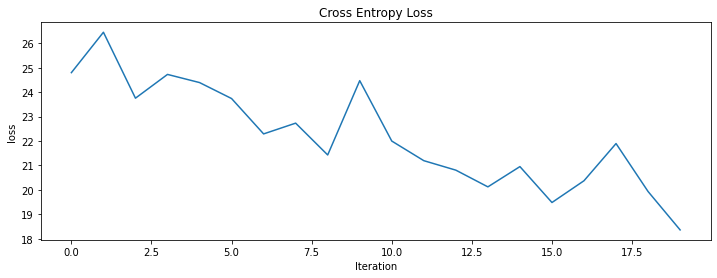

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(Loss)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');

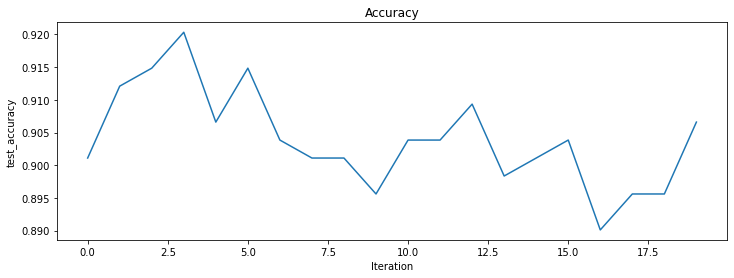

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(Acc)
plt.xlabel('Iteration')
plt.ylabel('test_accuracy')
plt.title('Accuracy');
